In [1]:
#library required
# import psycopg2

# from sqlalchemy import create_engine
# from sqlalchemy import text
import os
import time 
from datetime import datetime
import io 
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# Read the CSV file into a DataFrame
df_bh_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_us_22_08_24.csv")
df_bh_ca = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_ca_22_08_24.csv")
df_mp_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_us_22_08_24.csv")
df_mp_ca = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_ca_22_08_24.csv")


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_15028\3105605346.py:2: DtypeWarning: Columns (13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bh_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_bh_us_22_08_24.csv")
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_15028\3105605346.py:4: DtypeWarning: Columns (13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mp_us = pd.read_csv("C:/Users/Poovesh Kumar M/Downloads/Planning/1_Data/df_mp_us_22_08_24.csv")


In [3]:
# creating input df
df_bs1 = df_mp_us #chnage to load the df 


# Display the first few rows of the filtered DataFrame
print(df_bs1.head())


# Step 2: Create a list of distinct 'brand' and 'sales_channel' combinations
brands_channel_list = [f"{brand.replace('.', '_')}_{channel.replace('.', '_')}" 
                       for brand, channel in df_bs1[['brand', 'sales_channel']].drop_duplicates().values]

# Step 3: Convert the list to a single string, separated by commas
brands_channel_str = ', '.join(brands_channel_list)

# Display the combined string
print(brands_channel_str)

           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024-07-28      USD  14.99000          7   
1                  2022-10-01    2024-07-24      USD  14.99000          6   
2                  2022-10-01    2024-07-20      USD  14.99000          2   
3                  2022-10-01    2024-07-16      USD  15.15125          8   
4                  2022-10-01    2024-07-12      USD  14.99000          6   

   ...  ad_spend  inventory_available      category sub_category  \
0  ...  3.118138        

In [4]:
#creating New DF 
df_bs2 = df_bs1
# Display the first few rows of the filtered DataFrame
print(df_bs2.head())

#creating ASINx VB for mapping purpose
# Remove rows where 'asin' is null
df_asin_vb = df_bs2.dropna(subset=['asin'])

# Select distinct 'asin' and 'velocity_bucket' combinations
df_asin_vb = df_asin_vb[['asin', 'velocity_bucket']].drop_duplicates()

# Display the resulting DataFrame
print("Distinct asin x velocity_bucket:")
print(df_asin_vb.head())

           brand sales_channel  sales_date sale_month_year        asin  \
0  majestic pure    Amazon.com  2024-07-28         07-2024  B06XCCVDH7   
1  majestic pure    Amazon.com  2024-07-24         07-2024  B06XCCVDH7   
2  majestic pure    Amazon.com  2024-07-20         07-2024  B06XCCVDH7   
3  majestic pure    Amazon.com  2024-07-16         07-2024  B06XCCVDH7   
4  majestic pure    Amazon.com  2024-07-12         07-2024  B06XCCVDH7   

  earliest_date_brand_channel earliest_date currency       asp  gmv_units  \
0                  2022-10-01    2024-07-28      USD  14.99000          7   
1                  2022-10-01    2024-07-24      USD  14.99000          6   
2                  2022-10-01    2024-07-20      USD  14.99000          2   
3                  2022-10-01    2024-07-16      USD  15.15125          8   
4                  2022-10-01    2024-07-12      USD  14.99000          6   

   ...  ad_spend  inventory_available      category sub_category  \
0  ...  3.118138        

In [5]:
# Check for asin Mapped to Multiple velocity_bucket Values
# Group by 'asin' and count the number of unique 'velocity_bucket' values
asin_multiple_vb = df_asin_vb.groupby('asin')['velocity_bucket'].nunique()

# Filter to find asins that are mapped to more than one velocity_bucket
asin_with_multiple_vb = asin_multiple_vb[asin_multiple_vb > 1]

print("ASINs mapped to multiple velocity buckets:")
print(asin_with_multiple_vb)

# # Group by 'velocity_bucket' and count the number of unique 'asin' values
# vb_multiple_asin = df_asin_vb.groupby('velocity_bucket')['asin'].nunique()

# # Filter to find velocity_buckets that are mapped to more than one asin
# vb_with_multiple_asin = vb_multiple_asin[vb_multiple_asin > 1]

# print("Velocity buckets mapped to multiple ASINs:")
# print(vb_with_multiple_asin)

ASINs mapped to multiple velocity buckets:
Series([], Name: velocity_bucket, dtype: int64)


In [6]:
# Rolling up data - week level

# Convert 'sales_date' to datetime format if it isn't already
df_bs2['sales_date'] = pd.to_datetime(df_bs2['sales_date'])

# Extract the week and year, setting the week to start on Monday
df_bs2['year_week'] = df_bs2['sales_date'].dt.to_period('W-SUN').apply(lambda r: r.start_time.date())

# Group by 'asin' and 'year_week' to summarize 'gmv_units'
df_weekly = df_bs2.groupby(['asin', 'year_week'], as_index=False)['gmv_units'].sum()

print("Weekly summarized data:")
print(df_weekly.head())

# Pivot the monthly data to have 'asin' in rows and 'year_month' in columns
df_pivot_week = df_weekly.pivot(index='asin', columns='year_week', values='gmv_units').fillna(0)

# Reset index to make 'asin' a column
df_pivot_week.reset_index(inplace=True)

print("Pivoted data:")
print(df_pivot_week.head())


Weekly summarized data:
         asin   year_week  gmv_units
0  B00PMR3QF2  2022-09-26        368
1  B00PMR3QF2  2022-10-03       1227
2  B00PMR3QF2  2022-10-10       1655
3  B00PMR3QF2  2022-10-17       1489
4  B00PMR3QF2  2022-10-24       1742
Pivoted data:
year_week        asin  2022-09-26  2022-10-03  2022-10-10  2022-10-17  \
0          B00PMR3QF2       368.0      1227.0      1655.0      1489.0   
1          B00PV15BPW       390.0      1342.0      6396.0      1547.0   
2          B00Q7Z1UZ6         0.0         0.0         0.0         0.0   
3          B00Q96XGUU         5.0        25.0        17.0        29.0   
4          B00QR6SS6O        97.0       360.0      1279.0       409.0   

year_week  2022-10-24  2022-10-31  2022-11-07  2022-11-14  2022-11-21  ...  \
0              1742.0      1705.0      1654.0      1915.0      2475.0  ...   
1              1107.0      1154.0      1350.0      1500.0      3342.0  ...   
2                 0.0         0.0         0.0         0.0         0

In [7]:
df_weekly

,asin,year_week,gmv_units
0,B00PMR3QF2,2022-09-26,368
1,B00PMR3QF2,2022-10-03,1227
2,B00PMR3QF2,2022-10-10,1655
3,B00PMR3QF2,2022-10-17,1489
4,B00PMR3QF2,2022-10-24,1742
...,...,...,...
28623,B0D8HVYNM8,2024-07-01,0
28624,B0D8HVYNM8,2024-07-08,0
28625,B0D8HVYNM8,2024-07-15,0
28626,B0D8HVYNM8,2024-07-22,0


In [8]:
# Removing Outlier (IQR)

# Select the required columns from the original DataFrame
df_bs3 = df_weekly[['year_week', 'asin', 'gmv_units']]

# Define a function to remove outliers for each 'asin'
def remove_outliers(group):
    Q1 = group['gmv_units'].quantile(0.25)
    Q3 = group['gmv_units'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['gmv_units'] >= lower_bound) & (group['gmv_units'] <= upper_bound)]

# Apply the function to remove outliers for each 'asin'
df_bs3_no_outliers = df_bs3.groupby('asin').apply(remove_outliers).reset_index(drop=True)

# Display the DataFrame after removing outliers
print("DataFrame after removing outliers:")
print(df_bs3_no_outliers)


DataFrame after removing outliers:
        year_week        asin  gmv_units
0      2022-10-03  B00PMR3QF2       1227
1      2022-10-10  B00PMR3QF2       1655
2      2022-10-17  B00PMR3QF2       1489
3      2022-10-24  B00PMR3QF2       1742
4      2022-10-31  B00PMR3QF2       1705
...           ...         ...        ...
27444  2024-07-01  B0D8HVYNM8          0
27445  2024-07-08  B0D8HVYNM8          0
27446  2024-07-15  B0D8HVYNM8          0
27447  2024-07-22  B0D8HVYNM8          0
27448  2024-07-29  B0D8HVYNM8          0

[27449 rows x 3 columns]


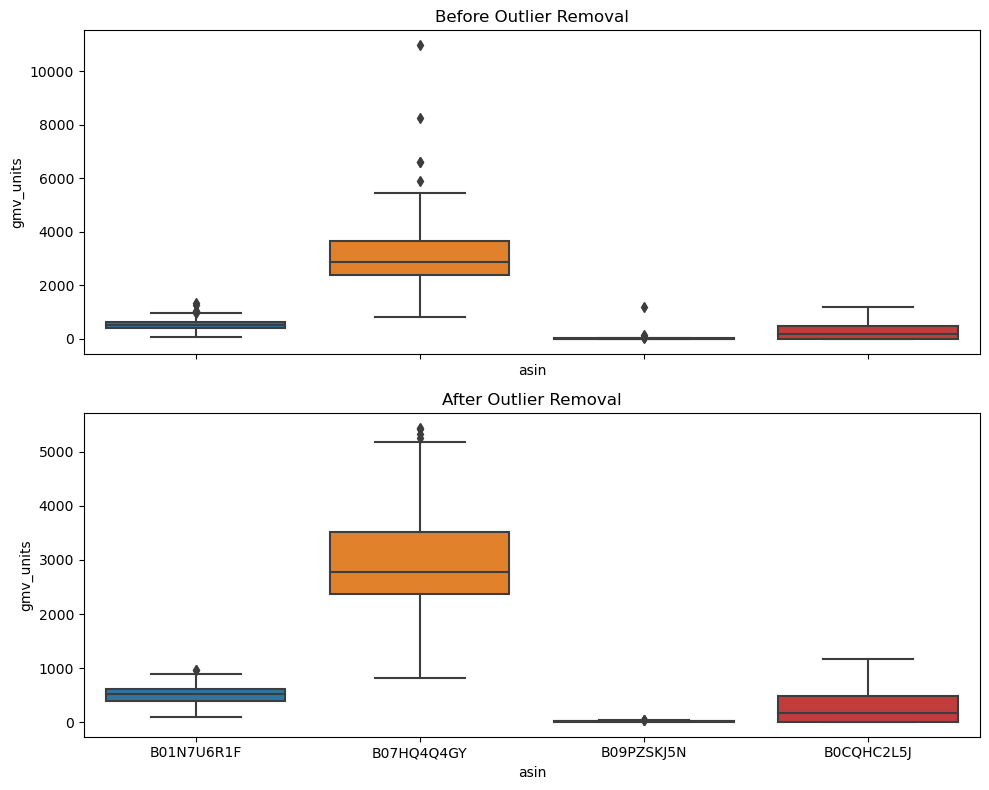

In [9]:
#Visualisation - Removing Outlier
#Visualisation of sample asin's - Box plot user input 

# Define the list of 'asin' values to visualize (replace with your own list)
sample_asins = ['B07HQ4Q4GY','B01N7U6R1F', 'B0CQHC2L5J', 'B09PZSKJ5N']  # Replace these with actual ASINs

# Filter the original and outlier-removed DataFrames for the selected 'asin' values
df_sample_before = df_weekly[df_weekly['asin'].isin(sample_asins)]
df_sample_after = df_bs3_no_outliers[df_bs3_no_outliers['asin'].isin(sample_asins)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the data before outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_before, ax=axes[0])
axes[0].set_title('Before Outlier Removal')

# Plot the data after outlier removal
sns.boxplot(x='asin', y='gmv_units', data=df_sample_after, ax=axes[1])
axes[1].set_title('After Outlier Removal')

# Display the plots
plt.tight_layout()
plt.show()

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_15028\1867095526.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_before['year_week'] = pd.to_datetime(df_sample_before['year_week'])
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_15028\1867095526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_after['year_week'] = pd.to_datetime(df_sample_after['year_week'])


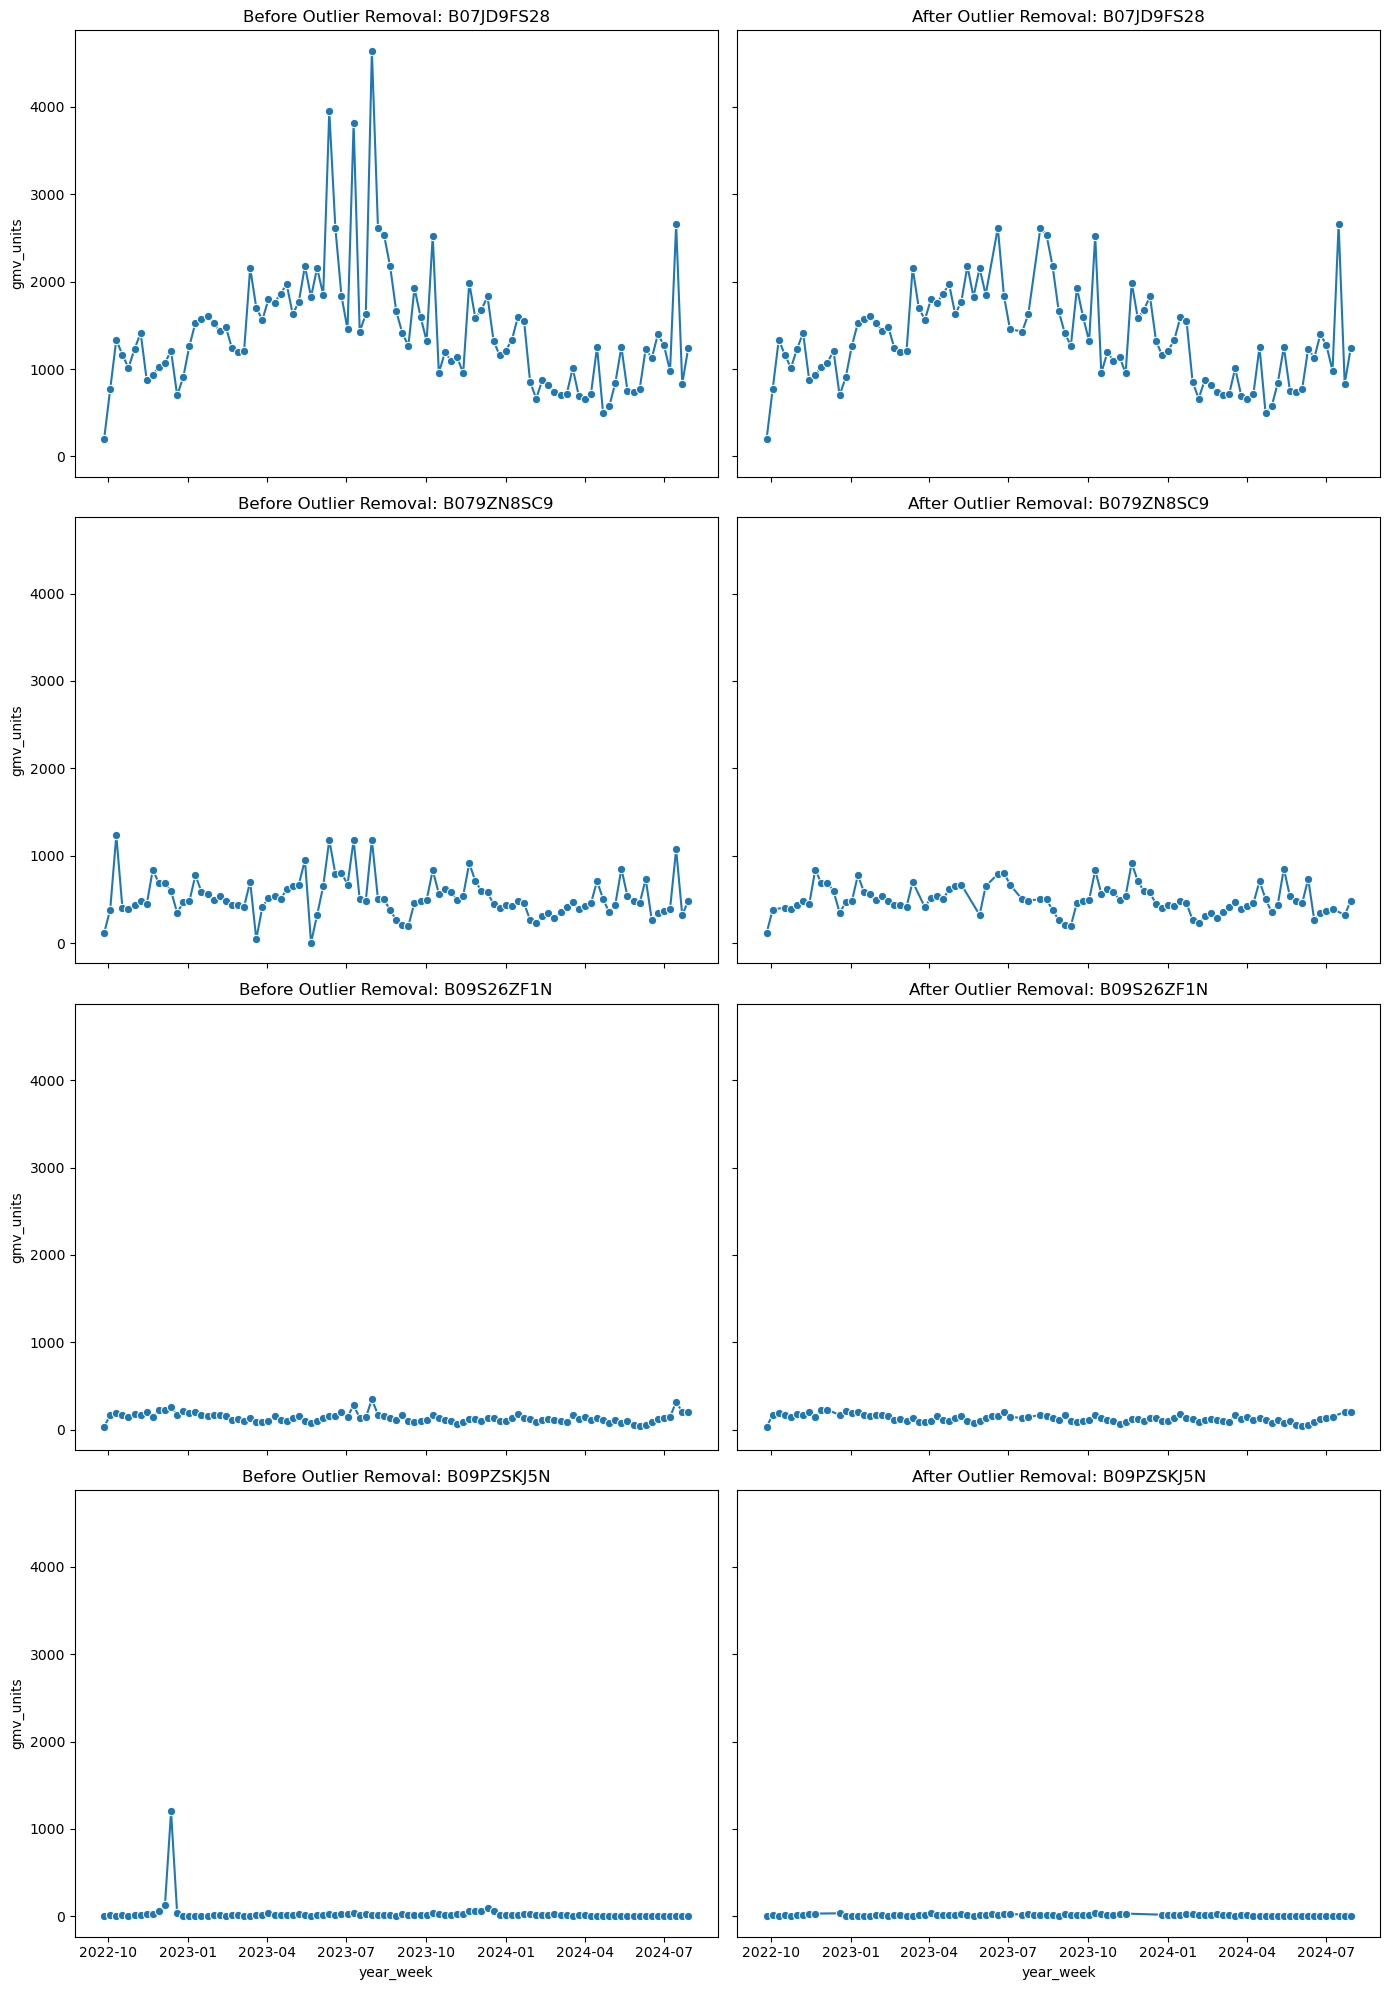

In [10]:
#Visualisation - Removing Outlier
#Visualisation of sample asin's - line chart user input 
# Define the list of 'asin' values to visualize
sample_asins = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']  # Replace with actual ASINs

# Filter the original and outlier-removed DataFrames for the selected 'asin' values
df_sample_before = df_weekly[df_weekly['asin'].isin(sample_asins)]
df_sample_after = df_bs3_no_outliers[df_bs3_no_outliers['asin'].isin(sample_asins)]

# Convert 'sales_date' to datetime if it's not already
df_sample_before['year_week'] = pd.to_datetime(df_sample_before['year_week'])
df_sample_after['year_week'] = pd.to_datetime(df_sample_after['year_week'])

# Set up the figure and axes
fig, axes = plt.subplots(len(sample_asins), 2, figsize=(14, len(sample_asins) * 5), sharex=True, sharey=True)

# Plot the data before outlier removal
for i, asin in enumerate(sample_asins):
    ax_before = axes[i, 0]
    ax_after = axes[i, 1]
    
    data_before = df_sample_before[df_sample_before['asin'] == asin]
    data_after = df_sample_after[df_sample_after['asin'] == asin]

    sns.lineplot(x='year_week', y='gmv_units', data=data_before, ax=ax_before, marker='o')
    sns.lineplot(x='year_week', y='gmv_units', data=data_after, ax=ax_after, marker='o')

    ax_before.set_title(f'Before Outlier Removal: {asin}')
    ax_after.set_title(f'After Outlier Removal: {asin}')

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
#Collecting Samples of ASINs vs Velocity Buckets vs monthly sales

# Assuming df_bs2 has 'asin' and 'velocity_bucket' columns
df_merged_week = df_asin_vb[['asin', 'velocity_bucket']].merge(df_pivot_week, on='asin', how='right')

# Reorder columns to have 'velocity_bucket', 'asin', and then the month-year columns
columns_order = ['velocity_bucket', 'asin'] + list(df_merged_week.columns[2:])
df_week = df_merged_week[columns_order]

# Replace null values in 'velocity_bucket' with a placeholder 'NULL'
df_week['velocity_bucket'] = df_week['velocity_bucket'].fillna('NULL')

# Define the custom order for velocity_bucket, using 'NULL' as the placeholder
custom_order = ['SF', 'F', 'M', 'SM', 'NULL']

# Convert 'velocity_bucket' to a categorical type with the custom order
df_week['velocity_bucket'] = pd.Categorical(df_week['velocity_bucket'], categories=custom_order, ordered=True)

# Sort the DataFrame by the custom order
df_week_sorted = df_week.sort_values(by='velocity_bucket').reset_index(drop=True)

# print("Final DataFrame:")
print("Final DataFrame sorted by velocity_bucket:")
print(df_week_sorted.head())

df_week_sorted.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/1_VB_ASIN_sales_week_year_'+brands_channel_str+'.csv')

Final DataFrame sorted by velocity_bucket:
  velocity_bucket        asin  2022-09-26  2022-10-03  2022-10-10  2022-10-17  \
0              SF  B00PMR3QF2       368.0      1227.0      1655.0      1489.0   
1              SF  B00PV15BPW       390.0      1342.0      6396.0      1547.0   
2              SF  B0C2Z44JLK         0.0         0.0         0.0         0.0   
3              SF  B07JD9FS28       200.0       772.0      1335.0      1164.0   
4              SF  B01BKB3C98       178.0       580.0       668.0       518.0   

   2022-10-24  2022-10-31  2022-11-07  2022-11-14  ...  2024-05-27  \
0      1742.0      1705.0      1654.0      1915.0  ...      1232.0   
1      1107.0      1154.0      1350.0      1500.0  ...      1308.0   
2         0.0         0.0         0.0         0.0  ...      2064.0   
3      1014.0      1230.0      1414.0       874.0  ...       738.0   
4       515.0       546.0       528.0       529.0  ...      1063.0   

   2024-06-03  2024-06-10  2024-06-17  2024-06-24

In [12]:
#Auto Arima Forecasting in Python
!pip install pmdarima

In [15]:
#Batches:

# df_weekly already exists and 'year_week' needs to be in datetime format
df_weekly['year_week'] = pd.to_datetime(df_weekly['year_week'])

# Manually specify the dates you're interested in removing
selected_dates = ['2024-05-06','2024-05-13','2024-05-20','2024-05-27','2024-06-03','2024-06-10','2024-06-17','2024-06-24',
                  '2024-07-01','2024-07-08','2024-07-15','2024-07-22','2024-07-29']



# Convert the dates to datetime format
selected_dates = pd.to_datetime(selected_dates)

# Filter the DataFrame to exclude the selected dates
df_batch1 = df_weekly[~df_weekly['year_week'].isin(selected_dates)]

# Display the resulting DataFrame
print("Filtered DataFrame with selected dates removed:")
print(df_batch1)

df_batch1.tail()

Filtered DataFrame with selected dates removed:
             asin  year_week  gmv_units
0      B00PMR3QF2 2022-09-26        368
1      B00PMR3QF2 2022-10-03       1227
2      B00PMR3QF2 2022-10-10       1655
3      B00PMR3QF2 2022-10-17       1489
4      B00PMR3QF2 2022-10-24       1742
...           ...        ...        ...
28464  B0CXDSCVJB 2024-04-15          0
28465  B0CXDSCVJB 2024-04-22          0
28466  B0CXDSCVJB 2024-04-29          0
28500  B0D1XNW89X 2024-04-29          0
28514  B0D4VHWB3C 2024-04-29          0

[24901 rows x 3 columns]


,asin,year_week,gmv_units
28464,B0CXDSCVJB,2024-04-15,0
28465,B0CXDSCVJB,2024-04-22,0
28466,B0CXDSCVJB,2024-04-29,0
28500,B0D1XNW89X,2024-04-29,0
28514,B0D4VHWB3C,2024-04-29,0


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_15028\4192109151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch1['year_week'] = pd.to_datetime(df_batch1['year_week'])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1368.039, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1548.287, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1402.646, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1490.545, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1368.653, Time=0.56 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1364.694, Time=0.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1455.514, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1388.638, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1359.650, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1357.378, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1355.858, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1357.6

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


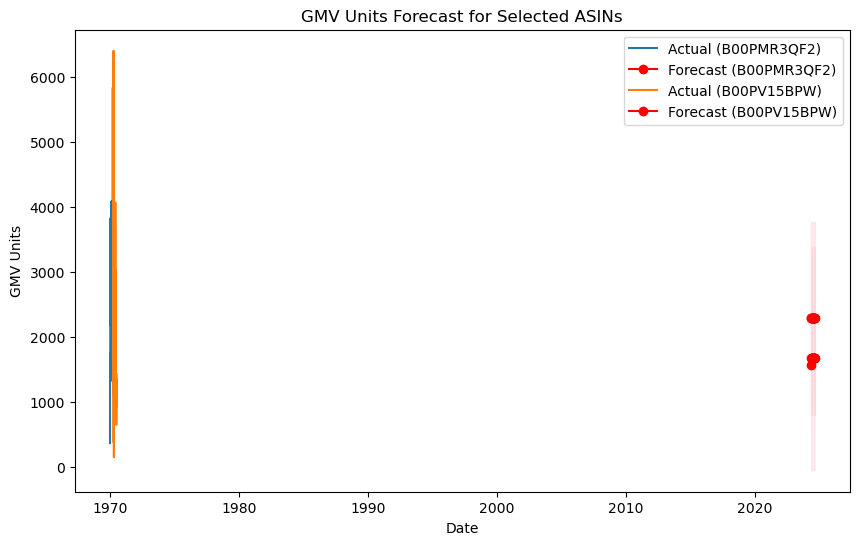

In [30]:
#version 2 : selected ASIN list
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Ensure 'year_month' is in datetime format
df_batch1['year_week'] = pd.to_datetime(df_batch1['year_week'])

# Set the 'year_month' column as the index
# df_batch1.set_index('year_month', inplace=True)

# List of ASINs to forecast and plot
selected_asins = ['B00PMR3QF2','B00PV15BPW']# 'B01767OTVK', 'B00Q96XGUU']  # Replace with actual ASINs

# Initialize a dictionary to store the forecast results
forecast_results = {}

# Input start date for the forecast
start_date = pd.to_datetime('2024-05-06')  # Replace with your desired start date

# Loop through each ASIN and perform forecasting
for asin in selected_asins:
    # Filter the DataFrame for the current ASIN
    df_asin = df_batch1[df_batch1['asin'] == asin]

    # Build the Auto ARIMA model
    model = auto_arima(df_asin['gmv_units'], 
                       seasonal=False, 
                       trace=True, 
                       suppress_warnings=True)

    # Forecast for the next 6 months
    forecast, conf_int = model.predict(n_periods=15, return_conf_int=True)

    # Create a DataFrame for the current ASIN's forecasts
    date_range = pd.date_range(start=start_date, periods=15, freq='W-MON')
    forecast_df = pd.DataFrame({
        'ASIN': asin,
        'forecast': forecast,
        'lower_conf_int': conf_int[:, 0],
        'upper_conf_int': conf_int[:, 1],
        'forecast_date': date_range
    })

    # Append to the forecast results DataFrame
    forecast_results[asin] = forecast_df

# Concatenate all the individual ASIN forecast DataFrames
df_forecasts = pd.concat(forecast_results.values(), ignore_index=True)

# Save the forecast results to a CSV file
# df_forecasts.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_forecast_results_selected_asin'+brands_channel_str+'.csv', index=False)

# Print part of the result
print(df_forecasts.head())

# Plot the results for each selected ASIN
plt.figure(figsize=(10, 6))

for asin in selected_asins:
    # Filter the actual data for the current ASIN
    df_asin = df_batch1[df_batch1['asin'] == asin]
    
    # Filter the forecast data for the current ASIN
    forecast_df = forecast_results[asin]
    forecast_dates = forecast_df['forecast_date']
    forecast_values = forecast_df['forecast']
    lower_conf_int = forecast_df['lower_conf_int']
    upper_conf_int = forecast_df['upper_conf_int']

    # Plot actual GMV units
    plt.plot(df_asin.index, df_asin['gmv_units'], label=f'Actual ({asin})')

    # Plot forecasted GMV units
    plt.plot(forecast_dates, forecast_values, label=f'Forecast ({asin})', marker='o', color='red')

    # Plot confidence interval
    plt.fill_between(forecast_dates, 
                     lower_conf_int, 
                     upper_conf_int, 
                     color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('GMV Units')
plt.title('GMV Units Forecast for Selected ASINs')
plt.legend()
plt.show()


In [28]:
# print(df_batch1.columns)
df_batch1

,asin,year_week,gmv_units
0,B00PMR3QF2,2022-09-26,368
1,B00PMR3QF2,2022-10-03,1227
2,B00PMR3QF2,2022-10-10,1655
3,B00PMR3QF2,2022-10-17,1489
4,B00PMR3QF2,2022-10-24,1742
...,...,...,...
28464,B0CXDSCVJB,2024-04-15,0
28465,B0CXDSCVJB,2024-04-22,0
28466,B0CXDSCVJB,2024-04-29,0
28500,B0D1XNW89X,2024-04-29,0


In [22]:
from pmdarima import auto_arima

# Ensure 'year_month' is in datetime format
df_batch1['year_week'] = pd.to_datetime(df_batch1['year_week'])

# List of ASINs to forecast and plot
selected_asins = df_batch1['asin'].unique()

# Initialize a dictionary to store the forecast results
forecast_results = {}

# Input start date for the forecast
start_date = pd.to_datetime('2024-05-06')  # Replace with your desired start date

# Loop through each ASIN and perform forecasting
for asin in selected_asins:
    # Filter the DataFrame for the current ASIN
    df_asin = df_batch1[df_batch1['asin'] == asin]
    
    if df_asin.empty:
        print(f"No data available for ASIN {asin}")
        continue

    if df_asin.shape[0] < 10:
        print(f"Not enough data for ASIN {asin} ({df_asin.shape[0]} data points)")
        continue

    if df_asin['gmv_units'].isnull().any():
        print(f"Missing values found for ASIN {asin}")
        continue

    # Build the Auto ARIMA model
    model = auto_arima(df_asin['gmv_units'], 
                       seasonal=False, 
                       trace=False, 
                       suppress_warnings=True)
    
    # Forecast for the next 6 months
    forecast, conf_int = model.predict(n_periods=15, return_conf_int=True)
    
    # Create a DataFrame for the current ASIN's forecasts
    date_range = pd.date_range(start=start_date, periods=15, freq='W-MON')
    forecast_df = pd.DataFrame({
        'ASIN': asin,
        'forecast': forecast,
        'lower_conf_int': conf_int[:, 0],
        'upper_conf_int': conf_int[:, 1],
        'forecast_date': date_range
    })
    
    # Append to the forecast results DataFrame
    forecast_results[asin] = forecast_df

# Concatenate all the individual ASIN forecast DataFrames
df_forecasts = pd.concat(forecast_results.values(), ignore_index=True)

# Save the forecast results to a CSV file
df_forecasts.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_forecast_results'+brands_channel_str+'.csv', index=False)

# Print part of the result
print(df_forecasts.head())

# # Plot the results for each selected ASIN
# plt.figure(figsize=(12, 8))

# for asin in selected_asins:
#     # Filter the actual data for the current ASIN
#     df_asin = df_batch1[df_batch1['asin'] == asin]
    
#     # Filter the forecast data for the current ASIN
#     forecast_df = forecast_results[asin]
#     forecast_dates = forecast_df['forecast_date']
#     forecast_values = forecast_df['forecast']
#     lower_conf_int = forecast_df['lower_conf_int']
#     upper_conf_int = forecast_df['upper_conf_int']

#     # Plot actual GMV units
#     plt.plot(df_asin['year_month'], df_asin['gmv_units'], label=f'Actual ({asin})')

#     # Plot forecasted GMV units
#     plt.plot(forecast_dates, forecast_values, label=f'Forecast ({asin})', marker='o', color='red')

#     # Plot confidence interval
#     plt.fill_between(forecast_dates, 
#                      lower_conf_int, 
#                      upper_conf_int, 
#                      color='pink', alpha=0.3)

# plt.xlabel('Date')
# plt.ylabel('GMV Units')
# plt.title('GMV Units Forecast for Selected ASINs')
# plt.legend()
# plt.show()


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_15028\2469930457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_batch1['year_week'] = pd.to_datetime(df_batch1['year_week'])
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: Value

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\sta

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\Poovesh Kumar M\anaconda3

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Poo

Not enough data for ASIN B0CXDH2LPP (5 data points)
Not enough data for ASIN B0CXDHX2QN (5 data points)
Not enough data for ASIN B0CXDRY3WC (5 data points)
Not enough data for ASIN B0CXDSCVJB (5 data points)
Not enough data for ASIN B0D1XNW89X (1 data points)
Not enough data for ASIN B0D4VHWB3C (1 data points)
         ASIN  forecast  lower_conf_int  upper_conf_int forecast_date
0  B00PMR3QF2   2282.75      801.325097     3764.174903    2024-05-06
1  B00PMR3QF2   2282.75      801.325097     3764.174903    2024-05-13
2  B00PMR3QF2   2282.75      801.325097     3764.174903    2024-05-20
3  B00PMR3QF2   2282.75      801.325097     3764.174903    2024-05-27
4  B00PMR3QF2   2282.75      801.325097     3764.174903    2024-06-03


C:\Users\Poovesh Kumar M\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# Ensure Sufficient Data Points
for asin in selected_asins:
    df_asin = df_batch1[df_batch1['asin'] == asin]
    
    if df_asin.shape[0] < 10:  # Example threshold
        print(f"Not enough data for ASIN {asin} ({df_asin.shape[0]} data points)")
        continue


#Accuracy Metrics for Time Series Forecast

import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                             # ME
    mae = np.mean(np.abs(forecast - actual))                    # MAE
    mpe = np.mean((forecast - actual) / actual)                 # MPE
    rmse = np.mean((forecast - actual) ** 2) ** 0.5             # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]                  # corr
    mins = np.amin(np.vstack([forecast, actual]), axis=0)
    maxs = np.amax(np.vstack([forecast, actual]), axis=0)
    minmax = 1 - np.mean(mins / maxs)                           # minmax
    acf1 = acf(forecast - actual, fft=False)[1]                 # ACF1
    return {'mape': mape, 'me': me, 'mae': mae, 
            'mpe': mpe, 'rmse': rmse, 'acf1': acf1, 
            'corr': corr, 'minmax': minmax}

# Assuming df_forecasts_with_actuals is your DataFrame
fc = df_forecasts_with_actuals['forecast'].values
actual = df_forecasts_with_actuals['actual'].values

accuracy_metrics = forecast_accuracy(fc, actual)

# Display the accuracy metrics
print(accuracy_metrics)

In [23]:
#Accuracy: MAPR & WAPE

#df_monthly contains actual data and df_forecasts contains forecast data

# Convert 'year_week' 'forecast_date' in df_forecasts to datetime
df_weekly['year_week'] = pd.to_datetime(df_weekly['year_week'])
df_forecasts['forecast_date'] = pd.to_datetime(df_forecasts['forecast_date'])

# Define the forecast dates of interest
forecast_dates = ['2024-05-06','2024-05-13','2024-05-20','2024-05-27','2024-06-03','2024-06-10','2024-06-17','2024-06-24',
                  '2024-07-01','2024-07-08','2024-07-15','2024-07-22','2024-07-29']
forecast_dates = pd.to_datetime(forecast_dates)

# Filter the forecast data for the dates of interest
df_forecasts_filtered = df_forecasts[df_forecasts['forecast_date'].isin(forecast_dates)]

# Filter the actual data for the dates of interest
df_weekly_filtered = df_weekly[df_weekly['year_week'].isin(forecast_dates)]

# Merge the actuals and forecasts on ASIN and date
df_merged = pd.merge(df_forecasts_filtered, df_weekly_filtered, left_on=['ASIN', 'forecast_date'],
                     right_on=['asin', 'year_week'])

# Calculate the Absolute Percentage Error
df_merged['absolute_percentage_error'] = abs((df_merged['forecast'] - df_merged['gmv_units']) / df_merged['gmv_units'])

# Calculate Absolute Errors
df_merged['absolute_error'] = abs(df_merged['forecast'] - df_merged['gmv_units'])

# Save the forecast results to a CSV file
df_merged.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_forecast_errors'+brands_channel_str+'.csv', index=False)


# Calculate MAPE for each forecast date
mape_per_date = df_merged.groupby('forecast_date')['absolute_percentage_error'].mean()

# Calculate WAPE for each forecast date
wape_per_date = df_merged.groupby('forecast_date').apply(
    lambda x: df_merged.loc[x.index, 'absolute_error'].sum() / df_merged.loc[x.index, 'gmv_units'].sum()
)

# Display MAPE and WAPE for each date
print("MAPE for each forecast date:")
print(mape_per_date)

print("\nWAPE for each forecast date:")
print(wape_per_date)

# Calculate overall MAPE and WAPE across all forecast dates
overall_mape = df_merged['absolute_percentage_error'].mean()
overall_wape = df_merged['absolute_error'].sum() / df_merged['gmv_units'].sum()

print(f"\nOverall MAPE: {overall_mape:.2%}")
print(f"Overall WAPE: {overall_wape:.2%}")


MAPE for each forecast date:
forecast_date
2024-05-06   NaN
2024-05-13   NaN
2024-05-20   NaN
2024-05-27   NaN
2024-06-03   NaN
2024-06-10   NaN
2024-06-17   NaN
2024-06-24   NaN
2024-07-01   NaN
2024-07-08   NaN
2024-07-15   NaN
2024-07-22   NaN
2024-07-29   NaN
Name: absolute_percentage_error, dtype: float64

WAPE for each forecast date:
forecast_date
2024-05-06    0.292650
2024-05-13    0.356642
2024-05-20    0.550789
2024-05-27    0.541512
2024-06-03    0.421362
2024-06-10    0.513635
2024-06-17    0.533955
2024-06-24    0.456407
2024-07-01    0.478912
2024-07-08    0.502747
2024-07-15    0.578277
2024-07-22    0.578192
2024-07-29    1.025574
dtype: float64

Overall MAPE: inf%
Overall WAPE: 51.26%


In [26]:
df_weekly_filtered1

,asin,velocity_bucket,year_week,gmv_units
0,B00PMR3QF2,SF,2024-05-06,5272
1,B00PMR3QF2,SF,2024-05-13,1774
2,B00PMR3QF2,SF,2024-05-20,1100
3,B00PMR3QF2,SF,2024-05-27,1232
4,B00PMR3QF2,SF,2024-06-03,4933
...,...,...,...,...
3722,B0D8HVYNM8,SM,2024-07-01,0
3723,B0D8HVYNM8,SM,2024-07-08,0
3724,B0D8HVYNM8,SM,2024-07-15,0
3725,B0D8HVYNM8,SM,2024-07-22,0


In [28]:
#Accuracy: MAPR & WAPE at velocity_bucket


df_weekly_filtered1 = df_asin_vb[['asin', 'velocity_bucket']].merge(df_weekly_filtered, on='asin', how='right')
df_forecasts_filtered1 = df_asin_vb[['asin', 'velocity_bucket']].merge(df_forecasts_filtered,left_on='asin', right_on='ASIN', how='right')


# Define the replacement dictionary
replacement_dict = {
    'SF': '1_SF',
    'F': '2_F',
    'M': '3_M',
    'SM': '4_SM',
    'NULL': 'NULL'
}

# Replace values in the 'velocity_bucket' column
df_weekly_filtered1['velocity_bucket'] = df_weekly_filtered1['velocity_bucket'].replace(replacement_dict)
df_forecasts_filtered1['velocity_bucket'] = df_forecasts_filtered1['velocity_bucket'].replace(replacement_dict)


# Group by 'velocity_bucket' and 'year_month' to summarize 'gmv_units'
df_weekly_filtered2 = df_weekly_filtered1.groupby(['velocity_bucket', 'year_week'], as_index=False)['gmv_units'].sum()
df_forecasts_filtered2 = df_forecasts_filtered1.groupby(['velocity_bucket', 'forecast_date'], as_index=False)['forecast'].sum()


# Merge the actuals and forecasts on ASIN and date
df_merged1 = pd.merge(df_forecasts_filtered2, df_weekly_filtered2, left_on=['velocity_bucket', 'forecast_date'],
                     right_on=['velocity_bucket', 'year_week'])

# Calculate the Absolute Percentage Error
df_merged1['absolute_percentage_error'] = abs((df_merged1['forecast'] - df_merged1['gmv_units']) / df_merged1['gmv_units'])

# Calculate Absolute Errors
df_merged1['absolute_error'] = abs(df_merged1['forecast'] - df_merged1['gmv_units'])

# # Calculate MAPE for each forecast date
# mape_per_date_bucket = df_merged1.groupby(['forecast_date', 'velocity_bucket'])['absolute_percentage_error'].mean().reset_index(name='MAPE')


wape_per_date_bucket = df_merged1.groupby(['forecast_date', 'velocity_bucket']).apply(
    lambda x: x['absolute_error'].sum() / x['gmv_units'].sum()
).reset_index(name='WAPE')

# # Display MAPE and WAPE for each date
# print("MAPE for each forecast date:")
# print(mape_per_date)

print("\nWAPE for each forecast date:")
print(wape_per_date_bucket)

# Calculate overall MAPE and WAPE across all forecast dates
# overall_mape = df_merged['absolute_percentage_error'].mean()
overall_wape = df_merged['absolute_error'].sum() / df_merged['gmv_units'].sum()

print(f"\nOverall MAPE: {overall_mape:.2%}")
print(f"Overall WAPE: {overall_wape:.2%}")

# Save the forecast results to a CSV file
wape_per_date_bucket.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_WAPE_buckets'+brands_channel_str+'.csv', index=False)



WAPE for each forecast date:
   forecast_date velocity_bucket      WAPE
0     2024-05-06            1_SF  0.098813
1     2024-05-06             2_F  0.101003
2     2024-05-06             3_M  0.023910
3     2024-05-06            4_SM  0.024475
4     2024-05-13            1_SF  0.009587
5     2024-05-13             2_F  0.003366
6     2024-05-13             3_M  0.121689
7     2024-05-13            4_SM  0.065942
8     2024-05-20            1_SF  0.614549
9     2024-05-20             2_F  0.059814
10    2024-05-20             3_M  0.130673
11    2024-05-20            4_SM  0.011701
12    2024-05-27            1_SF  0.703206
13    2024-05-27             2_F  0.153196
14    2024-05-27             3_M  0.132733
15    2024-05-27            4_SM  0.055456
16    2024-06-03            1_SF  0.015344
17    2024-06-03             2_F  0.096214
18    2024-06-03             3_M  0.005238
19    2024-06-03            4_SM  0.098653
20    2024-06-10            1_SF  0.215755
21    2024-06-10        

In [32]:
df_fc = df_merged[['asin','year_week', 'gmv_units','forecast','absolute_percentage_error', 'absolute_error']]

df_fc.rename(columns={'gmv_units': 'actuals'}, inplace=True)

# Save the forecast results to a CSV file
# df_fc_1.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/forecast_results_.csv', index=False)

df_fc_1 = df_fc[df_fc['year_week'] == '2024-05-06']
df_fc_2 = df_fc[df_fc['year_week'] == '2024-05-13']
df_fc_3 = df_fc[df_fc['year_week'] == '2024-05-20']
df_fc_4 = df_fc[df_fc['year_week'] == '2024-05-27']
df_fc_5 = df_fc[df_fc['year_week'] == '2024-06-03']
df_fc_6 = df_fc[df_fc['year_week'] == '2024-06-10']
df_fc_7 = df_fc[df_fc['year_week'] == '2024-06-17']
df_fc_8 = df_fc[df_fc['year_week'] == '2024-06-24']
df_fc_9 = df_fc[df_fc['year_week'] == '2024-07-01']
df_fc_10 = df_fc[df_fc['year_week'] == '2024-07-08']
df_fc_11 = df_fc[df_fc['year_week'] == '2024-07-15']
df_fc_12 = df_fc[df_fc['year_week'] == '2024-07-22']
df_fc_13 = df_fc[df_fc['year_week'] == '2024-07-29']


df_fc_1.head()
df_fc_2.head()
df_fc_3.head()

df_fc_13.tail()

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\1726211206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc.rename(columns={'gmv_units': 'actuals'}, inplace=True)


,asin,year_week,actuals,forecast,absolute_percentage_error,absolute_error
3466,B0CKXTLXSX,2024-07-29,10,119.834144,10.983414,109.834144
3479,B0CNVL174K,2024-07-29,4,89.499653,21.374913,85.499653
3492,B0CNVLTSDC,2024-07-29,80,4.187059,0.947662,75.812941
3505,B0CQH9FHZT,2024-07-29,39,91.553610,1.347528,52.553610
3518,B0CQHC2L5J,2024-07-29,79,56.150521,0.289234,22.849479


In [33]:
# Creating Actuals vs forcast table

# Define the year_month values you're interested in
year_week = ['2024-05-06','2024-05-13','2024-05-20','2024-05-27','2024-06-03','2024-06-10','2024-06-17','2024-06-24',
                  '2024-07-01','2024-07-08','2024-07-15','2024-07-22','2024-07-29']

# Sort by asin and year_month
df_fc_sorted = df_fc.sort_values(by=['asin', 'year_week'])

# Pivot the DataFrame
df_fc_pivot = df_fc_sorted.pivot(index='asin', columns='year_week', values=['actuals', 'forecast', 'absolute_percentage_error', 'absolute_error'])

# Flatten the MultiIndex in columns
# Create new column names
columns = []
for metric in ['actuals', 'forecast', 'absolute_percentage_error', 'absolute_error']:
    for i, month in enumerate(year_week):
        columns.append(f'{metric}_{i+1}')

df_fc_pivot.columns = columns

# Reset index to turn 'asin' back into a column
df_fc_result = df_fc_pivot.reset_index()

# Display the final DataFrame
print(df_fc_result)



           asin  actuals_1  actuals_2  actuals_3  actuals_4  actuals_5  \
0    B00PMR3QF2     5272.0     1774.0     1100.0     1232.0     4933.0   
1    B00PV15BPW     1220.0     1557.0     1183.0     1308.0     1442.0   
2    B00Q96XGUU       12.0        4.0        9.0        7.0       13.0   
3    B00QR6SS6O      736.0     1056.0      653.0      537.0      583.0   
4    B00QR7FTLU      132.0      124.0      166.0      143.0      153.0   
..          ...        ...        ...        ...        ...        ...   
268  B0CKXTLXSX      443.0      120.0       34.0       34.0      249.0   
269  B0CNVL174K      275.0       73.0       33.0       36.0      633.0   
270  B0CNVLTSDC      348.0      177.0      182.0      158.0      604.0   
271  B0CQH9FHZT      201.0      227.0      292.0      623.0      762.0   
272  B0CQHC2L5J      321.0      429.0      670.0      716.0      709.0   

     actuals_6  actuals_7  actuals_8  actuals_9  ...  absolute_error_4  \
0       1572.0     1724.0     1652.0 

In [34]:

# Calculate MAPE and WAPE for each forcast

# Initialize an empty DataFrame for the results
df_fc_result = pd.DataFrame(df_fc_result)  # Assuming df_fc_result is already initialized

# Loop through the DataFrames from df_fc_1 to df_fc_13
for i in range(1, 14):
    # Dynamically generate the DataFrame variable name
    df_fc = globals()[f'df_fc_{i}']
    
    # Calculate MAPE and WAPE for the current DataFrame
    mape_per_asin = df_fc.groupby('asin')['absolute_percentage_error'].mean().rename(f'mape_{i}')
    wape_per_asin = df_fc.groupby('asin').apply(
        lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
    
    # Merge the results into df_fc_result
    df_fc_result = df_fc_result.merge(mape_per_asin, on='asin', how='left')
    df_fc_result = df_fc_result.merge(wape_per_asin, on='asin', how='left')

# Display the final DataFrame
print(df_fc_result)


# The final df_fc_result will have all the joined columns
df_fc_result.head()


# # Display MAPE and WAPE for each ASIN
# print("MAPE for each ASIN:")
# print(mape_per_asin)

# print("\nWAPE for each ASIN:")
# print(wape_per_asin)



C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: divide by zero encountered in scalar

           asin  actuals_1  actuals_2  actuals_3  actuals_4  actuals_5  \
0    B00PMR3QF2     5272.0     1774.0     1100.0     1232.0     4933.0   
1    B00PV15BPW     1220.0     1557.0     1183.0     1308.0     1442.0   
2    B00Q96XGUU       12.0        4.0        9.0        7.0       13.0   
3    B00QR6SS6O      736.0     1056.0      653.0      537.0      583.0   
4    B00QR7FTLU      132.0      124.0      166.0      143.0      153.0   
..          ...        ...        ...        ...        ...        ...   
268  B0CKXTLXSX      443.0      120.0       34.0       34.0      249.0   
269  B0CNVL174K      275.0       73.0       33.0       36.0      633.0   
270  B0CNVLTSDC      348.0      177.0      182.0      158.0      604.0   
271  B0CQH9FHZT      201.0      227.0      292.0      623.0      762.0   
272  B0CQHC2L5J      321.0      429.0      670.0      716.0      709.0   

     actuals_6  actuals_7  actuals_8  actuals_9  ...    mape_9    wape_9  \
0       1572.0     1724.0     1652.

C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['absolute_error'].sum() / x['actuals'].sum()).rename(f'wape_{i}')
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_25900\3060960937.py:14: RuntimeWarning: divide by zero encountered in scalar

,asin,actuals_1,actuals_2,actuals_3,actuals_4,actuals_5,actuals_6,actuals_7,actuals_8,actuals_9,...,mape_9,wape_9,mape_10,wape_10,mape_11,wape_11,mape_12,wape_12,mape_13,wape_13
0,B00PMR3QF2,5272.0,1774.0,1100.0,1232.0,4933.0,1572.0,1724.0,1652.0,1597.0,...,0.429399,0.429399,0.332604,0.332604,0.615569,0.615569,0.558191,0.558191,2.522762,2.522762
1,B00PV15BPW,1220.0,1557.0,1183.0,1308.0,1442.0,2297.0,1799.0,1764.0,1624.0,...,0.028438,0.028438,0.056394,0.056394,0.586997,0.586997,0.506027,0.506027,0.345837,0.345837
2,B00Q96XGUU,12.0,4.0,9.0,7.0,13.0,4.0,8.0,6.0,5.0,...,3.033070,3.033070,inf,inf,4.109450,4.109450,inf,inf,inf,inf
3,B00QR6SS6O,736.0,1056.0,653.0,537.0,583.0,1610.0,329.0,464.0,646.0,...,0.249264,0.249264,0.247333,0.247333,0.684139,0.684139,0.356344,0.356344,0.156714,0.156714
4,B00QR7FTLU,132.0,124.0,166.0,143.0,153.0,121.0,110.0,116.0,104.0,...,0.185142,0.185142,0.196649,0.196649,0.257702,0.257702,0.621774,0.621774,1.622443,1.622443


In [35]:

# Merge the actuals and forecasts on ASIN and date

# Initialize the list with 'asin' as the first column
ordered_columns = ['asin']

# Loop through the indices from 1 to 13 to generate the column names
for i in range(1, 14):
    ordered_columns.extend([
        f'actuals_{i}', 
        f'forecast_{i}', 
        f'absolute_percentage_error_{i}', 
        f'absolute_error_{i}', 
        f'mape_{i}', 
        f'wape_{i}'
    ])

# Reorder the DataFrame according to the ordered_columns list
df_fc_result_error = df_fc_result[ordered_columns]

# Display the ordered DataFrame
print(df_fc_result_error)

df_fc_result_error = df_asin_vb[['asin', 'velocity_bucket']].merge(df_fc_result_error, on='asin', how='right')

# Define the replacement dictionary
replacement_dict = {
    'SF': '1_SF',
    'F': '2_F',
    'M': '3_M',
    'SM': '4_SM',
    'NULL': 'NULL'
}

# Replace values in the 'velocity_bucket' column
df_fc_result_error['velocity_bucket'] = df_fc_result_error['velocity_bucket'].replace(replacement_dict)


# Save the forecast results to a CSV file
df_fc_result_error.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/Weekly_forecast_final_'+brands_channel_str+'.csv', index=False)


df_fc_result_error.head()

           asin  actuals_1   forecast_1  absolute_percentage_error_1  \
0    B00PMR3QF2     5272.0  2282.750000                     0.567005   
1    B00PV15BPW     1220.0  1574.111544                     0.290255   
2    B00Q96XGUU       12.0    13.639158                     0.136597   
3    B00QR6SS6O      736.0   807.024415                     0.096501   
4    B00QR7FTLU      132.0   123.254820                     0.066251   
..          ...        ...          ...                          ...   
268  B0CKXTLXSX      443.0    58.935959                     0.866962   
269  B0CNVL174K      275.0    73.304560                     0.733438   
270  B0CNVLTSDC      348.0    72.529413                     0.791582   
271  B0CQH9FHZT      201.0   189.201791                     0.058698   
272  B0CQHC2L5J      321.0   262.573970                     0.182013   

     absolute_error_1    mape_1    wape_1  actuals_2   forecast_2  \
0         2989.250000  0.567005  0.567005     1774.0  2282.750000 

,asin,velocity_bucket,actuals_1,forecast_1,absolute_percentage_error_1,absolute_error_1,mape_1,wape_1,actuals_2,forecast_2,...,absolute_percentage_error_12,absolute_error_12,mape_12,wape_12,actuals_13,forecast_13,absolute_percentage_error_13,absolute_error_13,mape_13,wape_13
0,B00PMR3QF2,1_SF,5272.0,2282.750000,0.567005,2989.250000,0.567005,0.567005,1774.0,2282.750000,...,0.558191,817.750000,0.558191,0.558191,648.0,2282.750000,2.522762,1634.750000,2.522762,2.522762
1,B00PV15BPW,1_SF,1220.0,1574.111544,0.290255,354.111544,0.290255,0.290255,1557.0,1670.183398,...,0.506027,561.183398,0.506027,0.506027,1241.0,1670.183398,0.345837,429.183398,0.345837,0.345837
2,B00Q96XGUU,4_SM,12.0,13.639158,0.136597,1.639158,0.136597,0.136597,4.0,15.230621,...,inf,20.521186,inf,inf,0.0,20.582214,inf,20.582214,inf,inf
3,B00QR6SS6O,2_F,736.0,807.024415,0.096501,71.024415,0.096501,0.096501,1056.0,807.024415,...,0.356344,212.024415,0.356344,0.356344,957.0,807.024415,0.156714,149.975585,0.156714,0.156714
4,B00QR7FTLU,4_SM,132.0,123.254820,0.066251,8.745180,0.066251,0.066251,124.0,123.254820,...,0.621774,47.254820,0.621774,0.621774,47.0,123.254820,1.622443,76.254820,1.622443,1.622443


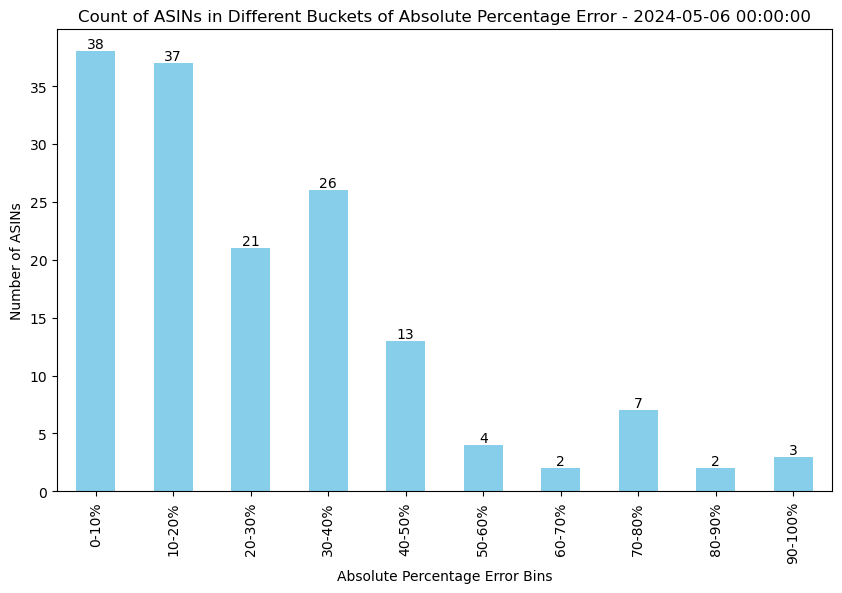

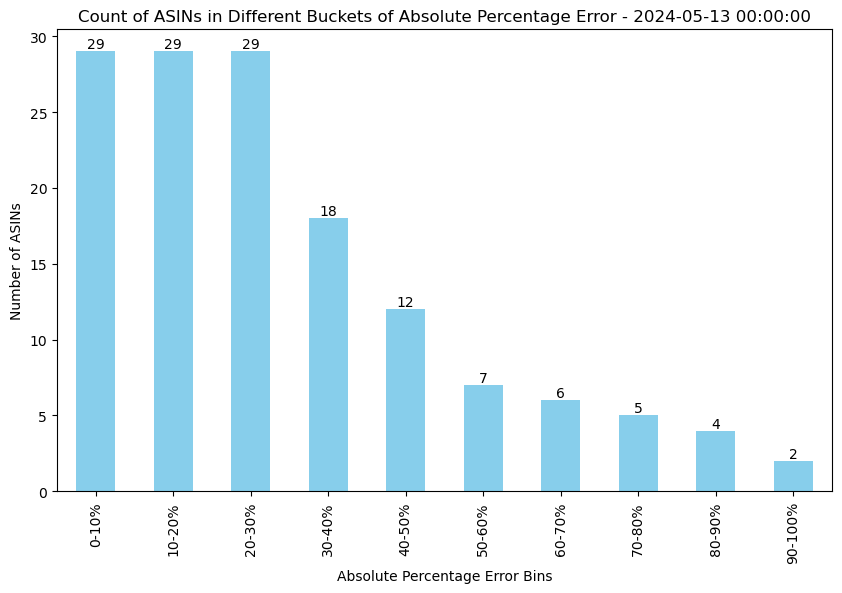

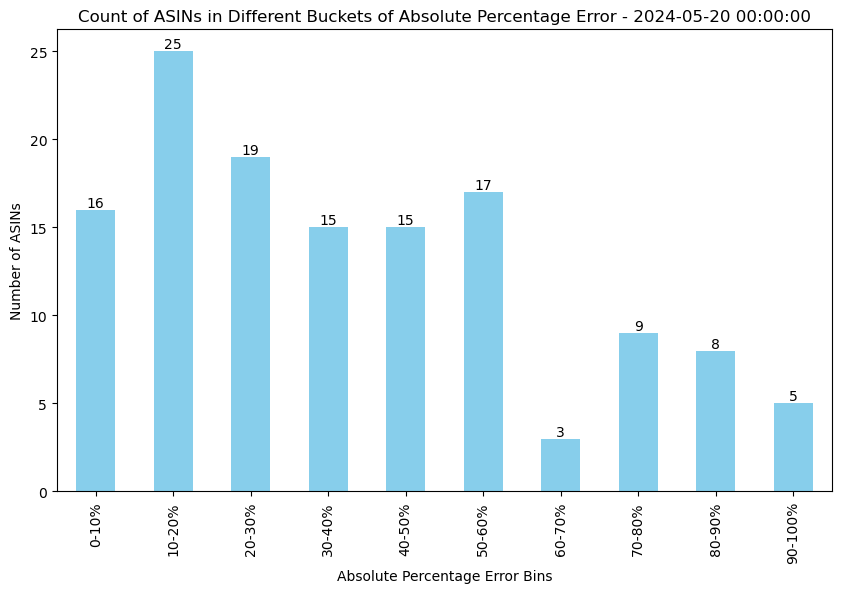

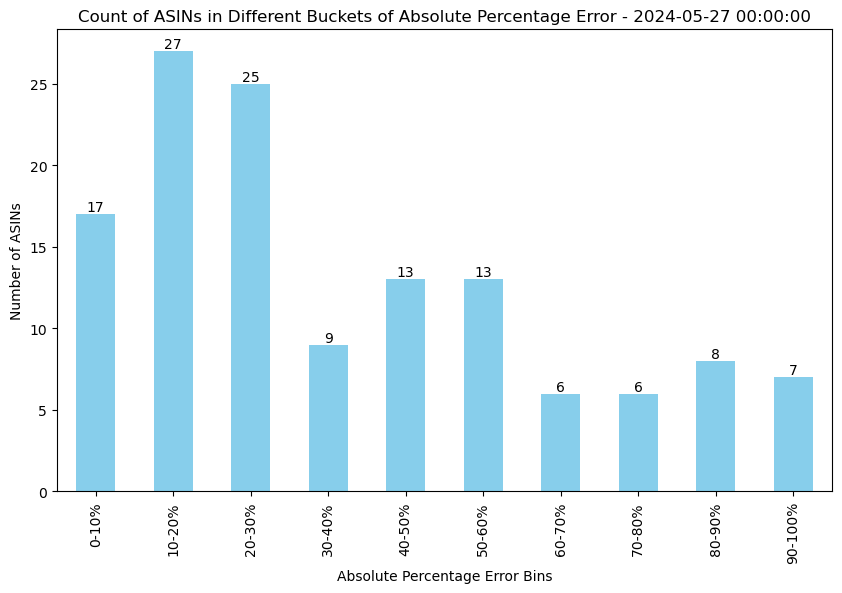

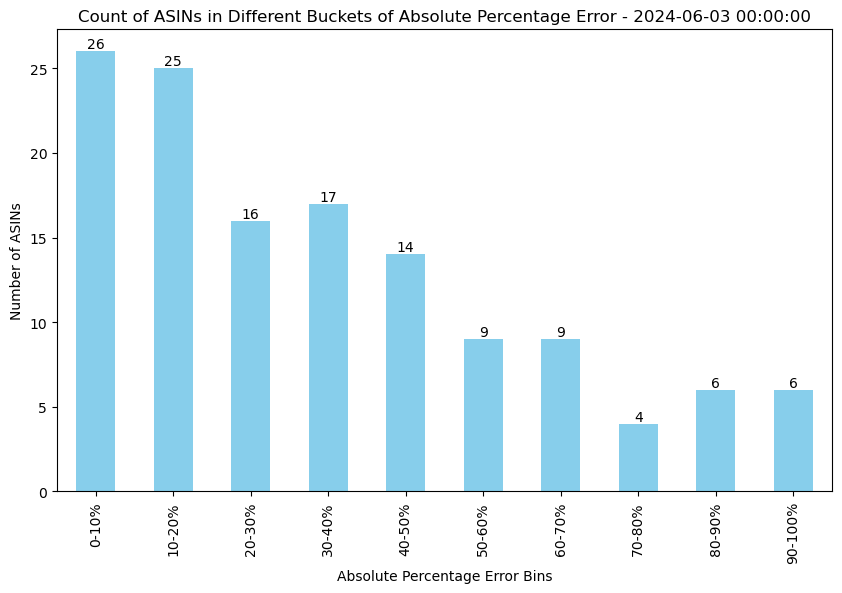

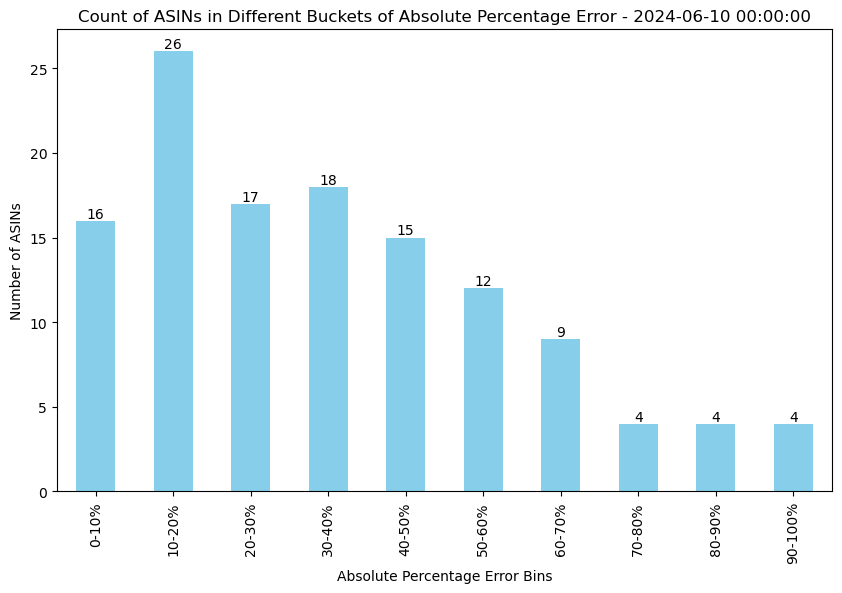

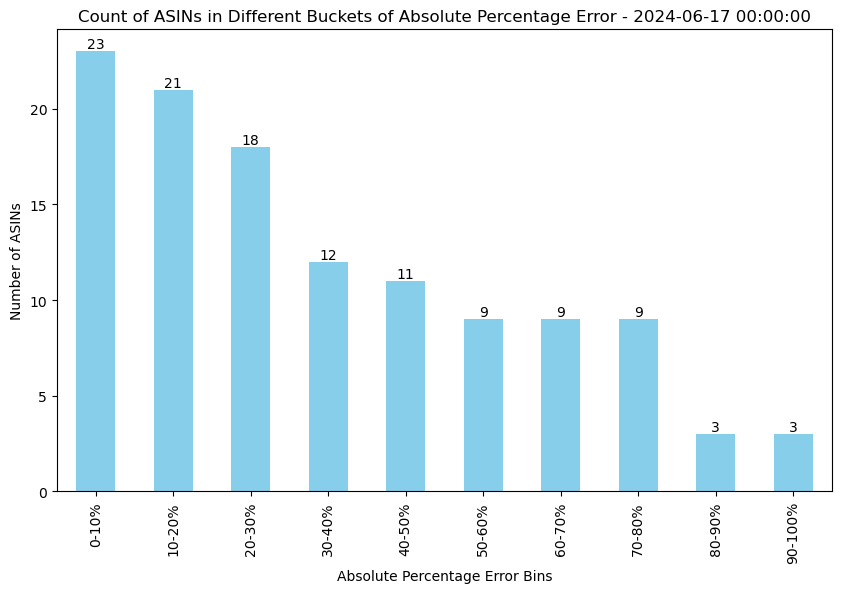

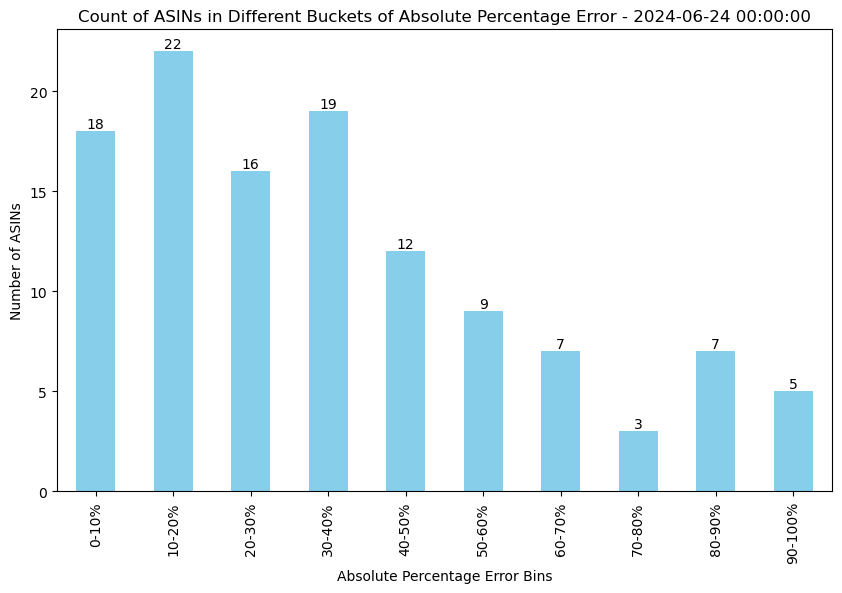

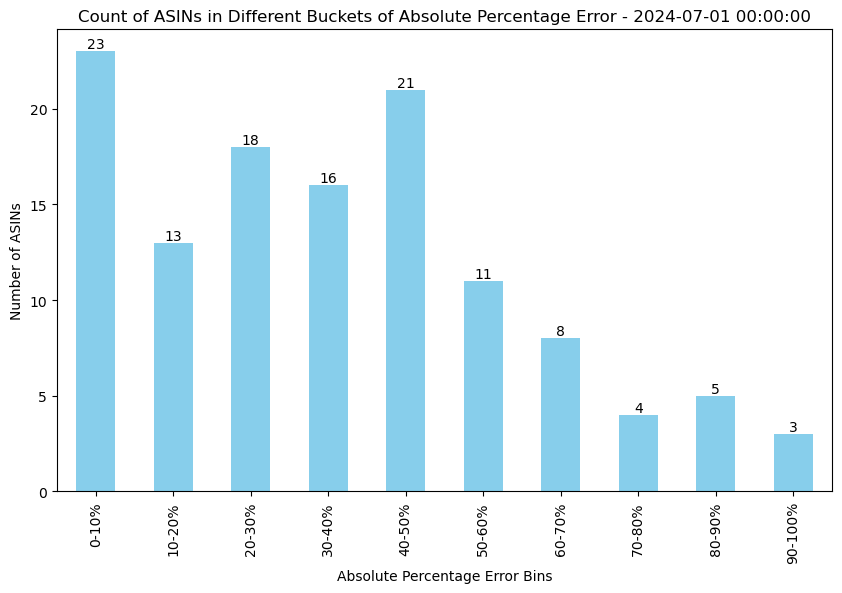

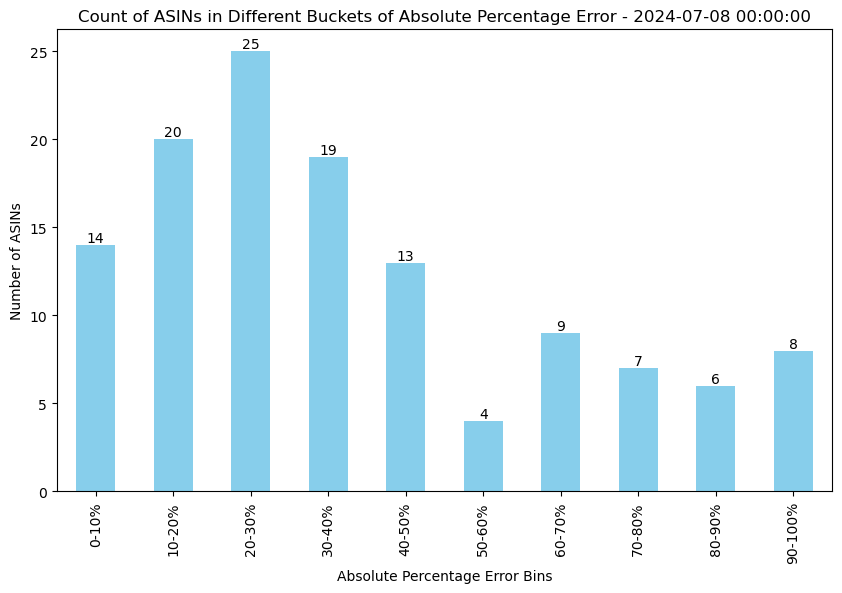

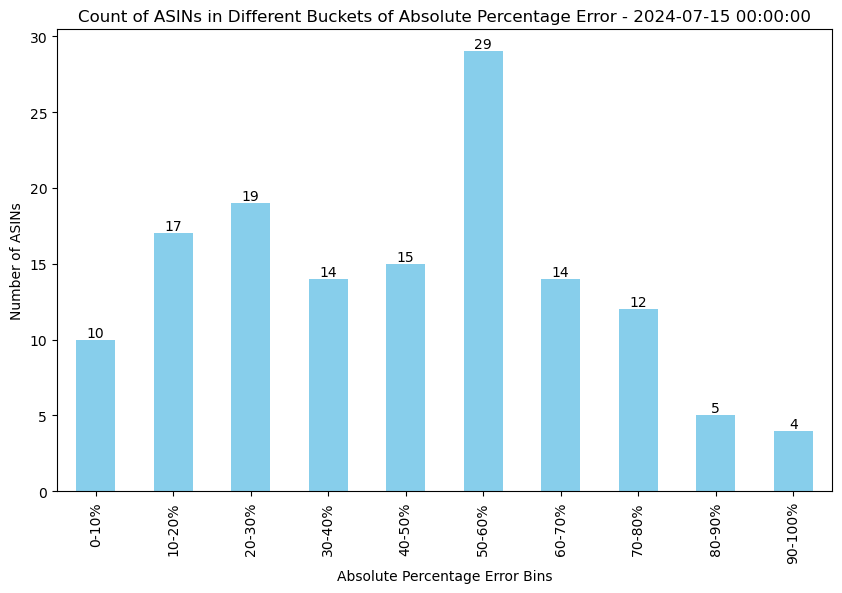

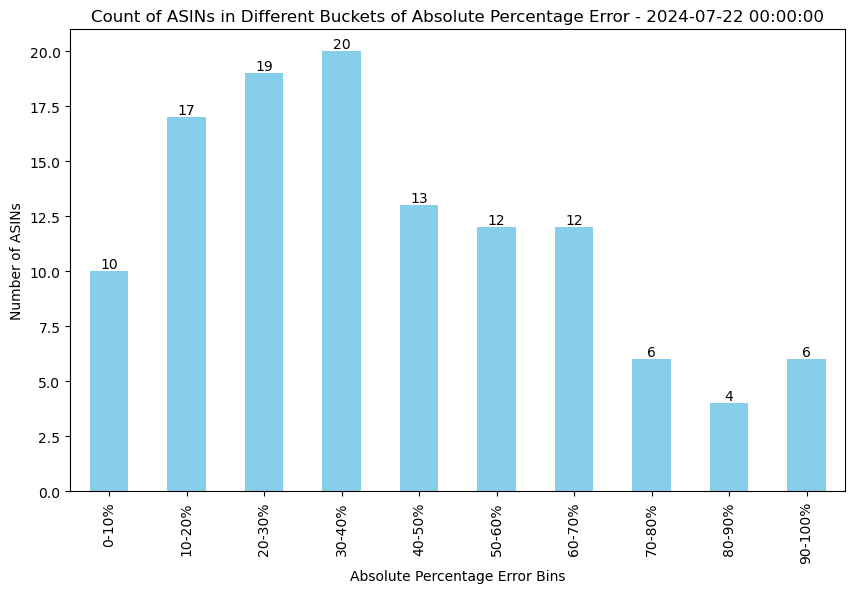

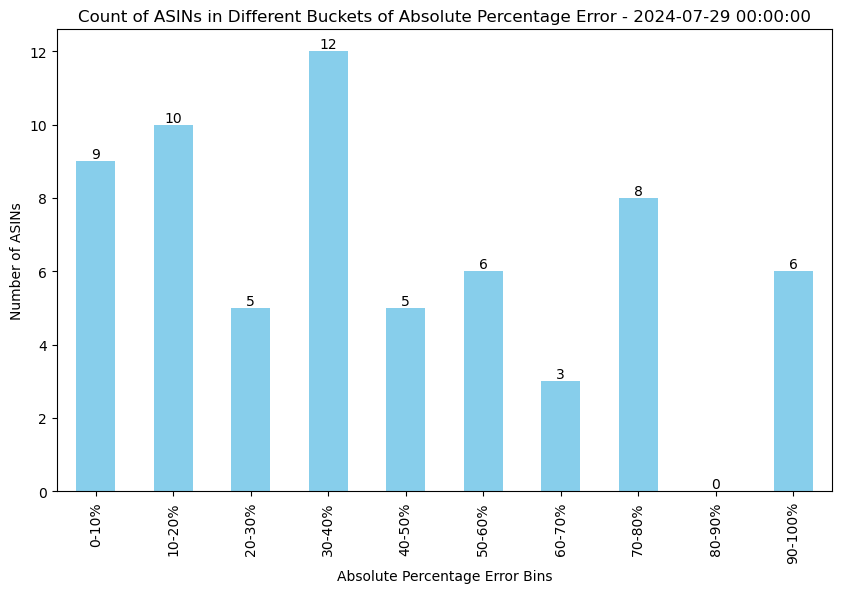

In [37]:
#Graphs with errors distribution


# Define the bins for absolute_percentage_error
bins = [0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Loop through the DataFrames from df_fc_1 to df_fc_13
for i in range(1, 14):
    # Dynamically select the DataFrame
    df_fc_ape = globals()[f'df_fc_{i}']
    
    # Create a new column in df_fc_ape with the binned absolute_percentage_error values
    df_fc_ape['error_bin'] = pd.cut(df_fc_ape['absolute_percentage_error'], bins=bins, labels=labels, right=False)
    
    # Count the number of ASINs in each bin
    asin_counts = df_fc_ape.groupby('error_bin')['asin'].nunique()
    
    # Extract the year_month value for the title (assuming it's the same for all rows)
    year_month = df_fc_ape['year_week'].iloc[0]
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    asin_counts.plot(kind='bar', color='skyblue')
    
    # Set plot title and labels
    plt.title(f'Count of ASINs in Different Buckets of Absolute Percentage Error - {year_month}')
    plt.xlabel('Absolute Percentage Error Bins')
    plt.ylabel('Number of ASINs')
    
    # Show the number of ASINs on top of each bar
    for index, value in enumerate(asin_counts):
        plt.text(index, value, str(value), ha='center', va='bottom')
    
    # Show the plot
    plt.show()

